## Quantum Optimal control to optimize the linear schedule

### Optimization of the quadratic driving

#### Imports

In [1]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
from src.qml_utils.utils import Schedule,SchedulerModel
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type
from scipy.optimize import minimize
from tqdm import trange

#### HyperParameters of the Optimal control

In [3]:
tf=3
nsteps=30
number_of_parameters=10


#### Initialize the system

In [4]:
file_name:str='data/usdb.nat'
qq_filename:str='data/qq.sd'


j_square_filename:str=file_name+'_j2'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies


nparticles_a:int=2
nparticles_b:int=0

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{8}$Be'


# Target Hamiltonian
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

TargetHamiltonian.get_hamiltonian()

matrix_qq,_=get_twobody_nuclearshell_model(file_name=qq_filename)
QQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
QQoperator.get_twobody_interaction(twobody_dict=matrix_qq)
QQoperator.get_hamiltonian()


# check the eigenstates
nlevels=5
egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)
print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)
egs=egs[0]
print(egs)
psi0=psis[:,:1]

print('deformation=',psi0.transpose().conjugate().dot(QQoperator.hamiltonian.dot(psi0)),'\n')

min_b=np.zeros(size_a+size_b)
min_b[0]=1
min_b[5]=1




print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=3


size= 24 12
Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:47<00:00,  1.96s/it]
9588it [00:09, 997.71it/s] 


Hamiltonian shape= (14, 14)
-11.931788251561516
deformation= [[-4.56315155]] 

initial state= [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
idx= 0
min energy= -9.3151


#### Span the free parameter space

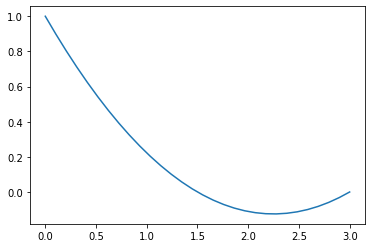

In [5]:
nsteps_b=50

bs=np.linspace(-2,2,nsteps_b)
energy_vs_b=np.zeros(nsteps_b)

time=np.linspace(0,tf,nsteps)
for j,b in enumerate(bs):
    psi=psi_configuration
    dt=time[1]-time[0]
    
    h=1-(1+b)*(time/tf)+b*(time/tf)**2
    
    for i,t in enumerate(time):
        time_hamiltonian=h[i]*InitialHamiltonian.hamiltonian+(1-h[i])*TargetHamiltonian.hamiltonian
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)

    energy_vs_b[j]=np.abs((psi.conjugate().transpose().dot(TargetHamiltonian.hamiltonian.dot(psi))-egs)/egs)
    psi=psi


plt.plot(time,h)
plt.show()

#### Results

0.02595165965088395


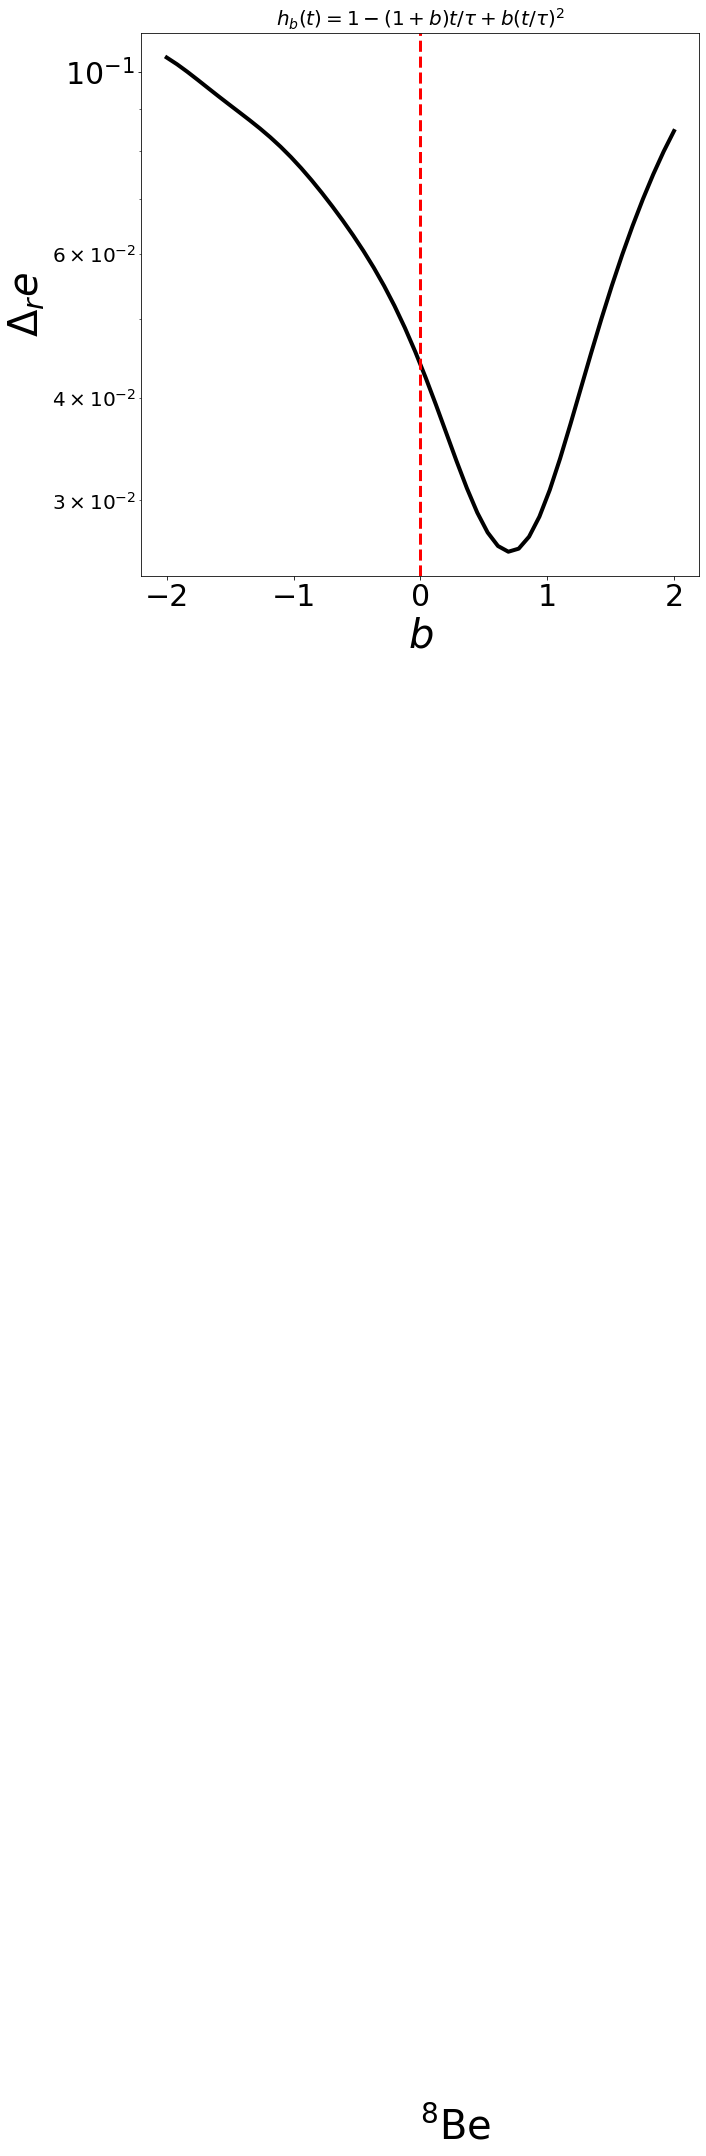

In [6]:
plt.figure(figsize=(10,10))
plt.title(r'$h_b(t)=1-(1+b)t/\tau+b(t/\tau)^2$',fontsize=20)
plt.plot(bs,energy_vs_b,linewidth=4,color='black')
plt.xlabel(r'$b$',fontsize=40)
plt.ylabel(r'$\Delta_r e$',fontsize=40)
print(0.999*np.min(energy_vs_b))
plt.text(s=title,x=0.,y=1-0.9997,fontsize=40)
plt.tick_params(labelsize=30)
plt.tick_params(labelsize=20,which='minor')
plt.axvline(x=0.,linewidth=3,color='red',linestyle='--')
plt.semilogy()
plt.show()

#### Minimum scheduler

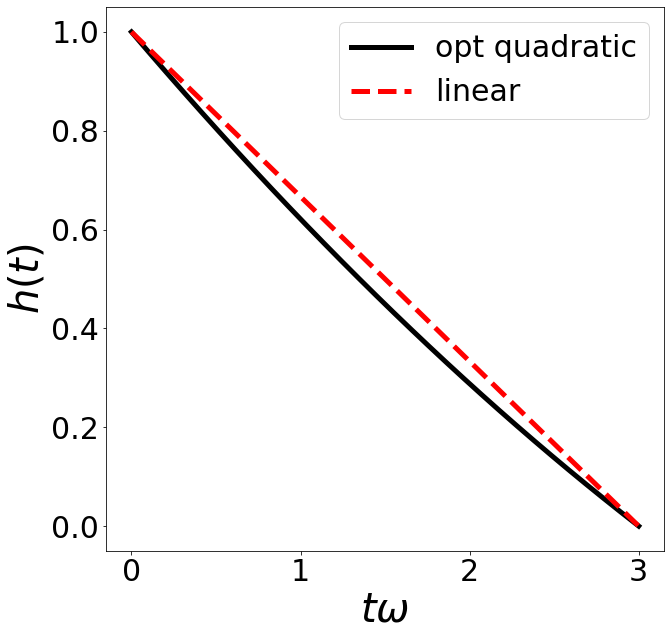

In [23]:
plt.figure(figsize=(10,10))
b_min=np.argmin(energy_vs_b)
h_quadratic=1-(1+bs[b_min])*(time/tf)+bs[b_min]*(time/tf)**2

h_driving_quadratic=h_quadratic
h_target_quadratic=1-h_quadratic

plt.xlabel(r'$t\omega$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.tick_params(labelsize=30)
plt.plot(time,h_quadratic,linewidth=5,color='black',label='opt quadratic')
plt.plot(time,1-time/tf,color='red',linewidth=5,linestyle='--',label='linear')
plt.legend(fontsize=30)
plt.show()



 comments go here

### General optimal control algorithm

#### Imports

In [24]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type,Optional
from scipy.optimize import minimize
from tqdm import trange

Plot some samples of the driving

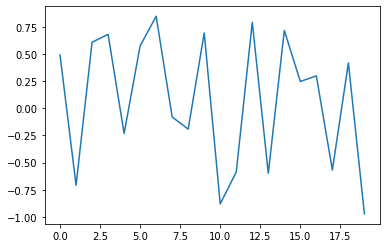

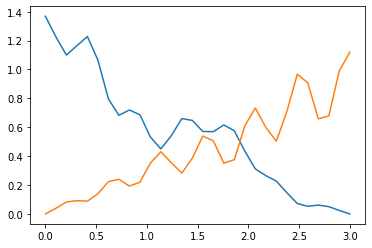

In [25]:
PowerLawScheduler=Schedule(tf=tf,type='F-CRAB',number_of_parameters=5,nsteps=nsteps,number_target_hamiltonians=1)

PowerLawScheduler.parameters=np.random.uniform(-1,1,size=PowerLawScheduler.parameters.shape[0])
plt.plot(PowerLawScheduler.parameters)
plt.show()
h_driver,h_target=PowerLawScheduler.get_driving()

plt.plot(PowerLawScheduler.time,h_driver)
plt.plot(PowerLawScheduler.time,h_target)

plt.show()

#### Optimization

In [26]:
model=SchedulerModel(initial_state=psi_configuration,target_hamiltonian=TargetHamiltonian.hamiltonian,initial_hamiltonian=InitialHamiltonian.hamiltonian,reference_hamiltonian=TargetHamiltonian.hamiltonian,tf=tf,nsteps=nsteps,number_of_parameters=number_of_parameters,type='power law',seed=42,mode='annealing ansatz')
print(model.parameters.shape)

res = minimize(
                    model.forward,
                    model.parameters,
                    method='L-BFGS-B',
                    tol=10**-6,
                    callback=model.callback,
                    options=None,
                    
                )

model.parameters = res.x
energy = model.forward(model.parameters)
print(energy,egs)
print(model.parameters)


(20,)
(-30.250257679738937+2.220446049250313e-16j)
(-30.275117866056846-1.7763568394002505e-15j)
(-30.27746997925957+0j)
(-30.28220158440384+1.7763568394002505e-15j)
(-30.282423205156377-4.440892098500626e-16j)
(-30.28293230568309+3.552713678800501e-15j)
(-30.283052954928717+8.881784197001252e-16j)
(-30.283574367011262+0j)
(-30.28406616626425-8.881784197001252e-16j)
(-30.284333829138827+0j)
(-30.284450002105636+0j)
(-30.28450893179899+0j)
(-30.284621933399038+0j)
(-30.28478957913926+0j)
(-30.284818177695808+0j)
-30.284818177695392 -30.29539461360556
[-1.32882634  4.03581249  1.2880973  -0.68590963 -1.22779454 -0.62993833
  0.95666072  1.64777281  2.5037985   3.00394223  3.60550103 -1.66927675
  0.75248006  2.58785724  2.83323182  2.82074988  2.33773225  1.53702473
  1.11736625  0.36848185]


0.0003491103530771357


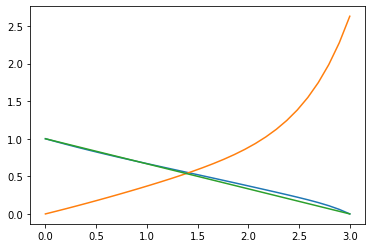

[0.99946854+0.j]


In [27]:
print(np.abs(energy-egs)/np.abs(egs))
h_driver,h_target=model.get_driving()
plt.plot(model.time,h_driver)
plt.plot(model.time,h_target)
plt.plot(model.time,1-model.time/model.tf)
plt.show()
print(model.psi.conjugate()@psi0*(psi0.conjugate().transpose() @ model.psi))

#### Check the performance with the quadratic optimization and the linear one

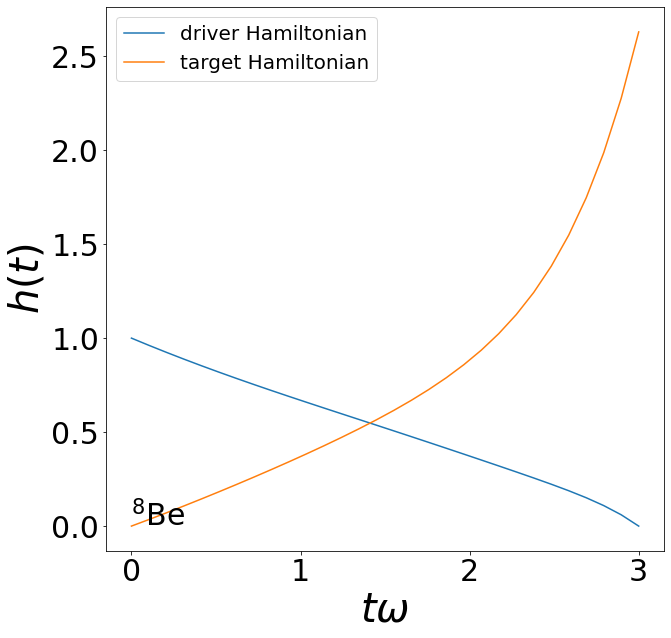

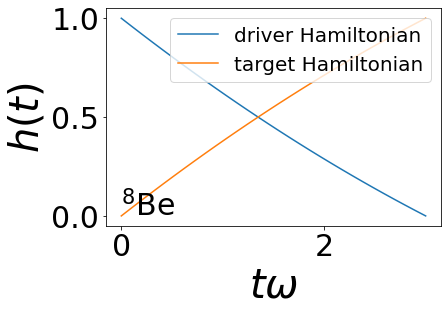

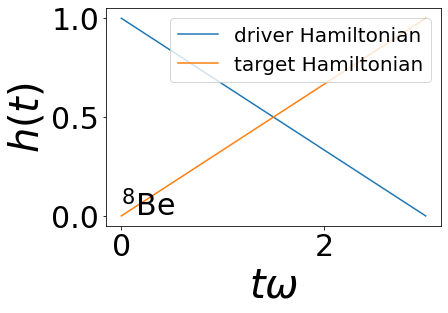

/tmp/ipykernel_1748800/4221505181.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  probabilities[r,j,i]=(


[0.00053146+0.j]
[0.01130787+0.j]
[0.0172248+0.j]


In [28]:

nlevels=10
quantum_annealing_info=True


h_driver,h_target=model.get_driving()

drivings=[(h_driver,h_target),(h_driving_quadratic,h_target_quadratic),(1-model.time/model.tf,model.time/model.tf)]
labels=['optimal control','quadratic optimization','linear']

probabilities=np.zeros((len(drivings),nlevels,nsteps))
spectrum=np.zeros_like(probabilities)


plt.figure(figsize=(10,10))
for i,drivers in enumerate(drivings):
    h_d,h_t=drivers
    plt.plot(time,h_d,label='driver Hamiltonian')
    plt.plot(time,h_t,label='target Hamiltonian')
    plt.tick_params(labelsize=30)
    plt.xlabel(r'$t \omega$',fontsize=40)
    plt.ylabel(r'$h(t)$',fontsize=40)
    plt.legend(fontsize=20)
    plt.text(s=title,x=0.,y=0.,fontsize=30)
    plt.show()
dt=model.time[1]-model.time[0]
energy=[]
fidelity=[]

for r,drivers in enumerate(drivings):
    h_d,h_t=drivers
    psi=psi_configuration
    for i,t in enumerate(model.time):
        time_hamiltonian=h_d[i]*InitialHamiltonian.hamiltonian+h_t[i]*TargetHamiltonian.hamiltonian
        linear_time_hamiltonian=(1-time[i]/tf)*InitialHamiltonian.hamiltonian+(time[i]/tf)*TargetHamiltonian.hamiltonian        
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)
        if quantum_annealing_info==True:
            values, psis = eigsh(linear_time_hamiltonian, k=nlevels, which="SA")
            spectrum[r,:, i] = values
            for j in range(values.shape[0]):
                probabilities[r,j,i]=(
                        psis[:, j].conjugate().transpose() @ psi[:]
                    ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])


    energy.append(np.abs((psi.conjugate().transpose().dot(TargetHamiltonian.hamiltonian.dot(psi))-egs)/egs))
    fidelity.append(1-(psi.conjugate()@psi0*(psi0.conjugate().transpose() @ psi)))
    print(fidelity[r])

### Probabilities

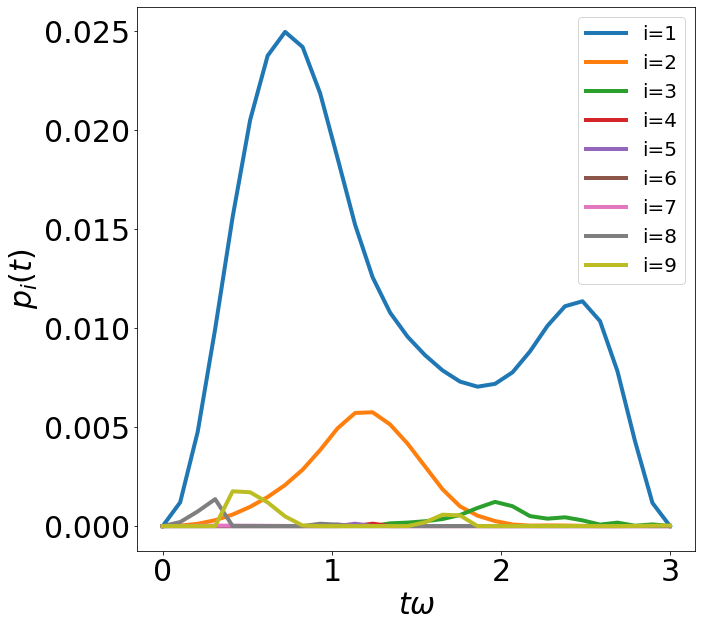

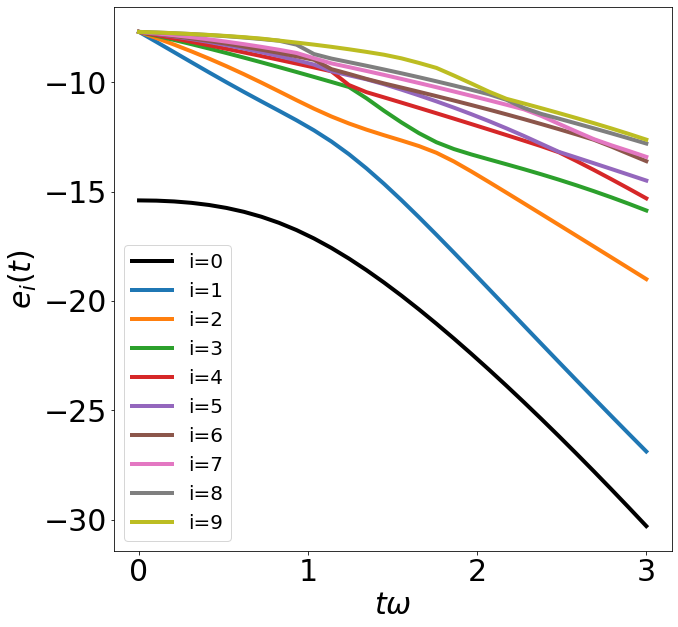

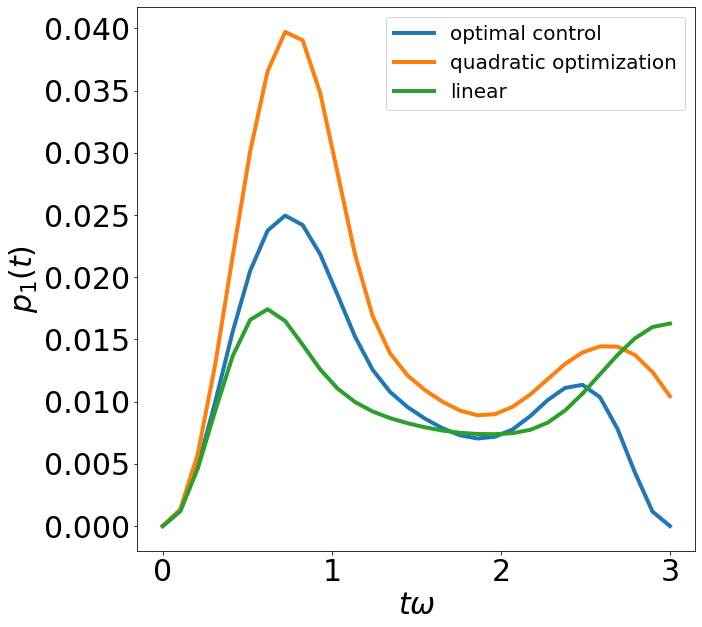

In [29]:
plt.figure(figsize=(10,10))
for i in range(1,nlevels):
    plt.plot(time,probabilities[0,i],label=f'i={i}',linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$p_i(t)$',fontsize=30)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time,spectrum[0,0],label=f'i={0}',linewidth=4,color='black')
for i in range(1,nlevels):
    plt.plot(time,spectrum[0,i],label=f'i={i}',linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$e_i(t)$',fontsize=30)
plt.show()


plt.figure(figsize=(10,10))
for i in range(len(drivings)):
    plt.plot(time,probabilities[i,1],label=labels[i],linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$p_1(t)$',fontsize=30)
plt.show()

##### Get the results

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


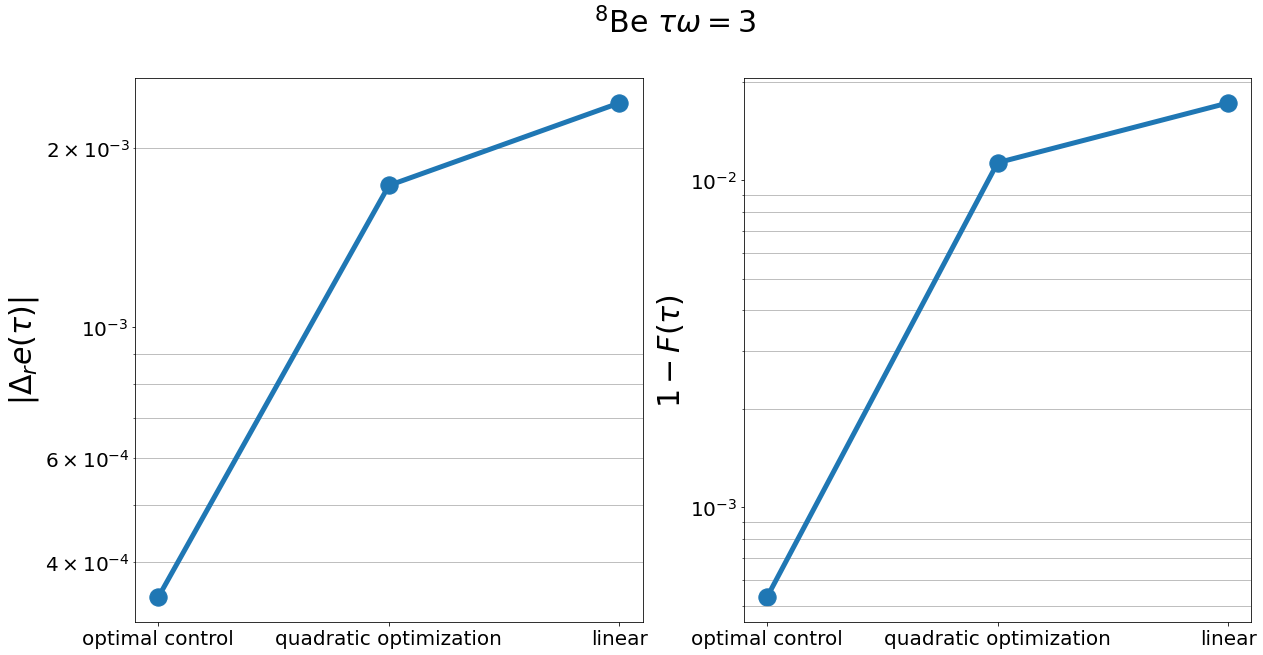

In [30]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
fig.suptitle(title+r' $\tau \omega=3$',fontsize=30)
ax[0].plot(energy,linewidth=5)
ax[0].scatter([0,1,2],energy,s=300)
ax[0].set_xticks([0,1,2],labels=labels)
ax[0].semilogy()
ax[0].set_ylabel(r'$|\Delta_r e(\tau)|$',fontsize=30)
ax[0].tick_params(labelsize=20)
ax[0].tick_params(labelsize=20,which='minor')
ax[0].grid(True,which='minor')

ax[1].plot(fidelity,linewidth=5)
ax[1].scatter([0,1,2],fidelity,s=300)
ax[1].set_xticks([0,1,2],labels=labels,fontsize=30)
ax[1].semilogy()
ax[1].set_ylabel(r'$1-F(\tau)$',fontsize=30)
ax[1].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20,which='minor')
ax[1].grid(True,which='minor')
plt.show()

### Test the transfer Learning

In [34]:
file_name:str='data/usdb.nat'
qq_filename:str='data/qq.sd'

j_square_filename:str=file_name+'_j2'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies


nparticles_a:int=4
nparticles_b:int=4

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{24}$Mg'


# Target Hamiltonian
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

TargetHamiltonian.get_hamiltonian()

# check the eigenstates
nlevels=2
egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)
print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)
egs=egs[0]
print(egs)
psi0=psis[:,:1]


# matrix_qq,_=get_twobody_nuclearshell_model(file_name=qq_filename)
# QQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# QQoperator.get_twobody_interaction(twobody_dict=matrix_qq)
# QQoperator.get_hamiltonian()

#### Initial Hamiltonian
min_b=np.zeros(size_a+size_b)

if file_name=='data/cki':
    order_of_filling=np.asarray([0,3,1,2,4,5])
    order_of_filling_protons=order_of_filling+size_a
else:
    order_of_filling=np.asarray([0,5,1,4,2,3,6,7,8,11,9,10])
    order_of_filling_protons=order_of_filling+size_a


min_b[order_of_filling[:nparticles_a]]=1
min_b[order_of_filling_protons[:nparticles_b]]=1




print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

nlevels=3
nlevels=3

size= 24 12
Hamiltonian shape= (28503, 28503)
-92.7752030732139
initial state= [1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
idx= 558
min energy= -75.29519365079362


Annealing with the transfer learning for the different drivings

(100,)


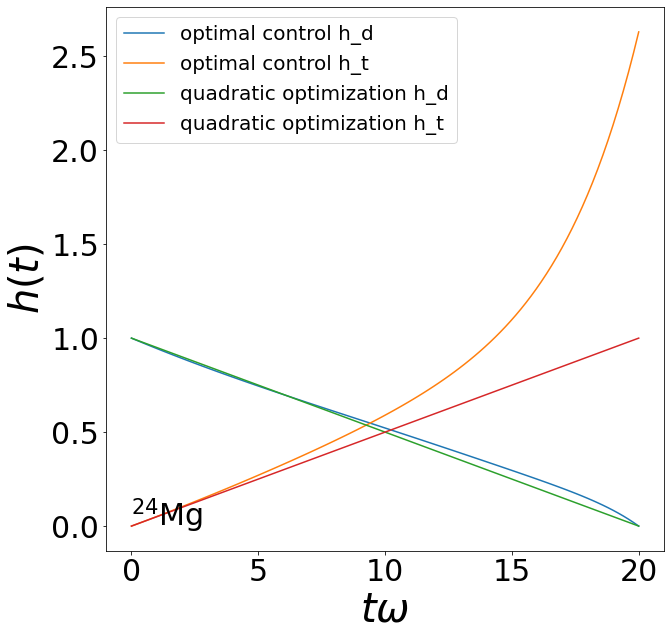

/tmp/ipykernel_1748800/3063502993.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  probabilities[r,j,i]=(


IndexError: index 30 is out of bounds for axis 2 with size 30

In [ ]:
nlevels=3
quantum_annealing_info=True
model.tf=20

model.time=np.linspace(0,20,100)

h_driver,h_target=model.get_driving()
print(h_driver.shape)
drivings=[(h_driver,h_target),(1-model.time/model.tf,model.time/model.tf)]
labels=['optimal control','quadratic optimization','linear']

probabilities=np.zeros((len(drivings),nlevels,model.time.shape[0]))
spectrum=np.zeros_like(probabilities)


plt.figure(figsize=(10,10))
for i,drivers in enumerate(drivings):
    h_d,h_t=drivers
    plt.plot(model.time,h_d,label=labels[i]+' h_d')
    plt.plot(model.time,h_t,label=labels[i]+' h_t')
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=40)
plt.ylabel(r'$h(t)$',fontsize=40)
plt.legend(fontsize=20)
plt.text(s=title,x=0.,y=0.,fontsize=30)
plt.show()
dt=model.time[1]-model.time[0]
energy=[]
fidelity=[]

for r,drivers in enumerate(drivings):
    h_d,h_t=drivers
    psi=psi_configuration
    for i,t in enumerate(model.time):
        time_hamiltonian=h_d[i]*InitialHamiltonian.hamiltonian+h_t[i]*TargetHamiltonian.hamiltonian
        linear_time_hamiltonian=(1-model.time[i]/tf)*InitialHamiltonian.hamiltonian+(model.time[i]/tf)*TargetHamiltonian.hamiltonian        
        psi=expm_multiply(-1j*dt*time_hamiltonian,psi)
        if quantum_annealing_info==True:
            values, psis = eigsh(linear_time_hamiltonian, k=nlevels, which="SA")
            spectrum[r,:, i] = values
            for j in range(values.shape[0]):
                probabilities[r,j,i]=(
                        psis[:, j].conjugate().transpose() @ psi[:]
                    ) * np.conj(psis[:, j].conjugate().transpose() @ psi[:])


    energy.append(np.abs((psi.conjugate().transpose().dot(TargetHamiltonian.hamiltonian.dot(psi))-egs)/egs))
    fidelity.append(1-(psi.conjugate()@psi0*(psi0.conjugate().transpose() @ psi)))
    print(fidelity[r])

#### Results

Probabilities

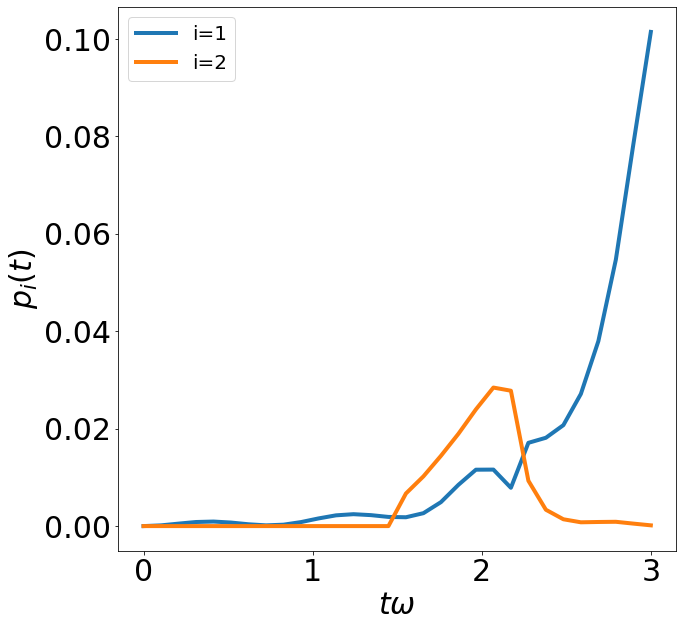

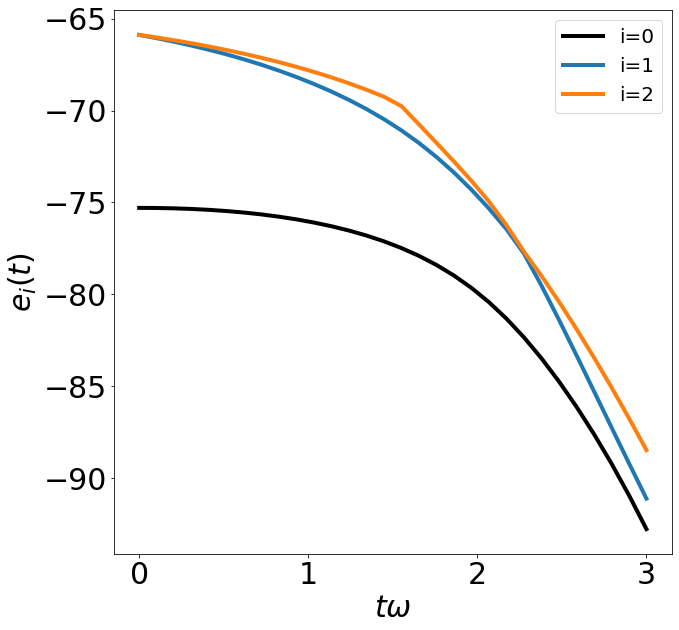

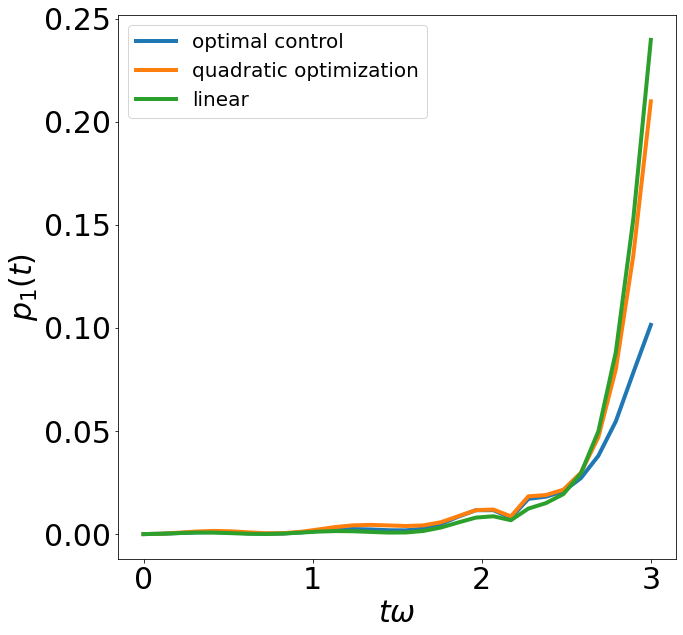

In [36]:
plt.figure(figsize=(10,10))
for i in range(1,nlevels):
    plt.plot(time,probabilities[0,i],label=f'i={i}',linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$p_i(t)$',fontsize=30)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time,spectrum[0,0],label=f'i={0}',linewidth=4,color='black')
for i in range(1,nlevels):
    plt.plot(time,spectrum[0,i],label=f'i={i}',linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$e_i(t)$',fontsize=30)
plt.show()


plt.figure(figsize=(10,10))
for i in range(len(drivings)):
    plt.plot(time,probabilities[i,1],label=labels[i],linewidth=4)
plt.legend(fontsize=20)
plt.tick_params(labelsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$p_1(t)$',fontsize=30)
plt.show()

Accuracy

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


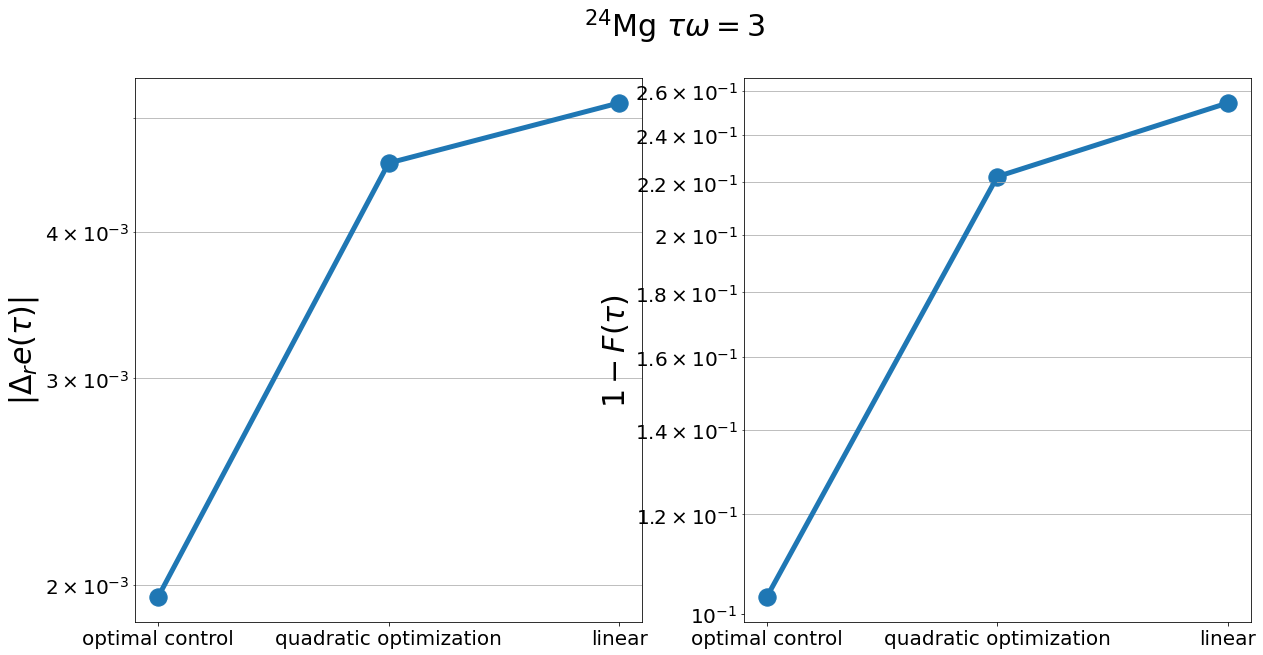

In [37]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
fig.suptitle(title+r' $\tau \omega=3$',fontsize=30)
ax[0].plot(energy,linewidth=5)
ax[0].scatter([0,1,2],energy,s=300)
ax[0].set_xticks([0,1,2],labels=labels)
ax[0].semilogy()
ax[0].set_ylabel(r'$|\Delta_r e(\tau)|$',fontsize=30)
ax[0].tick_params(labelsize=20)
ax[0].tick_params(labelsize=20,which='minor')
ax[0].grid(True,which='minor')

ax[1].plot(fidelity,linewidth=5)
ax[1].scatter([0,1,2],fidelity,s=300)
ax[1].set_xticks([0,1,2],labels=labels,fontsize=30)
ax[1].semilogy()
ax[1].set_ylabel(r'$1-F(\tau)$',fontsize=30)
ax[1].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20,which='minor')
ax[1].grid(True,which='minor')
plt.show()